# Code Notebook 2: NLP EDA #

In this notebook, I will conduct EDA to identify useful characteristics of the data.
- Experiment with different values of max_df
- Identify stop words, frequent words, and trends in the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
corpus = pd.read_csv('../data/corpus.csv')

### Section 6: Experimenting with max_df to find a good cutoff ###

In [3]:
def token_lem(in_str):
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    tokenized = tokenizer.tokenize(in_str)
    lemmatized = [lemmatizer.lemmatize(token.lower()) for token in tokenized if len(token) > 1]
    return lemmatized

The sklearn vectorizers don't lemmatize by default.  The above function will manually apply a simple tokenizer and lemmatizer.  It only returns words with at least 2 characters.  The default vectorizer preprocessing is maintained.

I found information about the default tokenizer and modifying it here:

https://kavita-ganesan.com/how-to-use-countvectorizer/#.YYPkjS-B2Ak

https://stackoverflow.com/questions/23850256/how-can-i-pass-a-preprocessor-to-tfidfvectorizer-sklearn-python

In [4]:
count_vec = CountVectorizer(tokenizer=token_lem, min_df=5, max_features=10_000)

In [5]:
vector = count_vec.fit_transform(corpus['body'])

In [6]:
vec_df = pd.DataFrame(vector.todense(), columns=count_vec.get_feature_names_out())

In [7]:
top_100_full = vec_df.sum().sort_values(ascending=False)[:100]

The 100 most common words in the corpus.

In [8]:
count_vec = CountVectorizer(tokenizer=token_lem, max_df=0.2, min_df=5, max_features=10_000)

In [9]:
vector = count_vec.fit_transform(corpus['body'])

In [10]:
vec_df = pd.DataFrame(vector.todense(), columns=count_vec.get_feature_names_out())

In [11]:
top_100 = vec_df.sum().sort_values(ascending=False)[:100]

The 100 most common words in the corpus that appear in fewer than 20% of documents.

In [12]:
[word for word in top_100_full.index if word not in top_100.index]

['the',
 'to',
 'and',
 'of',
 'it',
 'that',
 'is',
 'in',
 'you',
 'for',
 'are',
 'be',
 'not',
 'this',
 'but']

The list above is all the common words in the corpus that appear in more than 20% of documents.  I used CountVectorizer to get this simple count, although I plan to use TfidfVectorizer for modeling.  Since all of these words are stop words, and .2 already seems like a pretty restrictive max_df, I will not use max_df for modelling, but will include these as stop words.

### Section 7: Top Words and Trends ###

The stop words list below includes the words noted in the previous section.  It also has words that were added after looking at top words and trends.  See below.

In [13]:
stop_words = ['the', 'to', 'and', 'of', 'it', 'that', 'is', 'in', 'you', 'for', 'are', 'be', 'not', 'this', 'but',
             'we', 'they', 'on', 'have', 'with', 'can', 'a', 'if', 'or', 'just', 'people', 'would', 'so', 'like',
             'more', 'all', 'there', 'at', 'what', 'from', 'about', 'do', 'an', 'wa', 'by', 'don', 'one', 'get',
             'how', 'their', 'no', 'than', 'your', 're', 'ha', 'think', 'out', 'because', 'thing', 'even', 'my',
             'will', 'year', 'up', 'make', 'need', 'them', 'when', 'could', 'some', 'only', 'much', 'gt', 'which',
             'way', 'also', 'then', 'other', 'now', 'who', 'http', 'being', 'know', 'why', 'good', 'most', 'any',
             'still', 'see', 'really', 'should', 'me', 'these', 'he', 'time', 'u', 'our', 'into', 'going', 'go',
             'want', 'work', 'use', 'been', 'well', 'those', 'take', 'where', 'point', 'mean', 'very', 'lot',
             'problem', 'over', 'here', 'say', 'something', 'right', 'doesn', 'many', 'same', 'isn',
             'too', 'were', 've', 'actually', 'every', 'le', 'had', 'used', 'www', 'sure']

In [14]:
future_df = corpus[corpus['subreddit'] == 'Futurology'].copy()
science_df = corpus[corpus['subreddit'] == 'science'].copy()

In [15]:
count_vec = CountVectorizer(tokenizer=token_lem, stop_words=stop_words, min_df=5, max_features=10_000)

In [16]:
future_vec = count_vec.fit_transform(future_df['body'])
future_vec_df = pd.DataFrame(future_vec.todense(), columns=count_vec.get_feature_names_out())

In [17]:
# Top 50 words in the science subreddit after stop word removal.
future_top_50 = future_vec_df.sum().sort_values(ascending=False)[:50]

In [18]:
science_vec = count_vec.fit_transform(science_df['body'])
science_vec_df = pd.DataFrame(science_vec.todense(), columns=count_vec.get_feature_names_out())

In [19]:
# Top 50 words in the science subreddit after stop word removal.
science_top_50 = science_vec_df.sum().sort_values(ascending=False)[:50]

In [20]:
future_top_50[:5]

space     2718
solar     2363
energy    2207
power     1933
money     1572
dtype: int64

In [21]:
science_top_50[:5]

study      2267
covid      1917
vaccine    1877
science    1259
woman      1217
dtype: int64

This analysis reveals the presence of several more words that should be stop words.  The stop words list above reflects the presence of stop words that were added after they appeared among the top words here.

In [22]:
# Words that appear in both top 50 lists
both_top_50 = [word for word in future_top_50.index if word in science_top_50.index]

In [23]:
both_top_50

['life',
 'human',
 'change',
 'long',
 'better',
 'com',
 'day',
 'doe',
 'while',
 'first',
 'never',
 'without',
 'anything',
 'said']

After removing several stop words, I've reached a point where most of these look like they could make a substantive difference, epecially in bigrams.

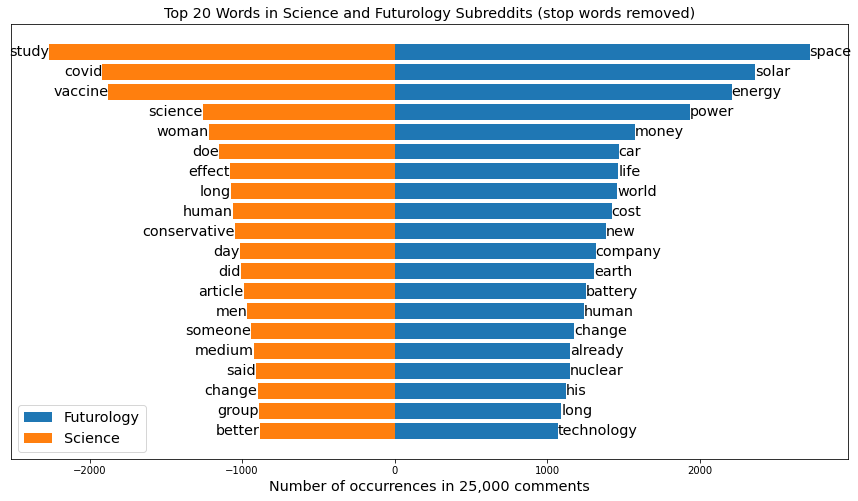

In [24]:
plt.figure(figsize=(15,8))
plot1 = plt.barh(np.linspace(1,20,20), future_top_50[19::-1])
plt.bar_label(plot1, future_top_50.index[19::-1], fontsize='x-large')
plot2 = plt.barh(np.linspace(1,20,20), -science_top_50[19::-1])
plt.bar_label(plot2, science_top_50.index[19::-1], fontsize='x-large')
plt.yticks(ticks=[])
plt.title('Top 20 Words in Science and Futurology Subreddits (stop words removed)', fontsize='x-large')
plt.xlabel('Number of occurrences in 25,000 comments', fontsize='x-large')
plt.legend([plot1, plot2], ['Futurology', 'Science'], fontsize='x-large');

The above chart shows the top twenty words in 25,000 comments for each subreddit after stop word removal.  It could be argued that words like "said" and "his" are stop words, but they were as frequent in both subreddits as the stop words I chose.  Also, they could be substantive ("said" may be more common in science because it is more common to reference prior information, for example).

Themes suggested by this chart:
- The science subreddit, being focused on current research, tends to focus on current issues much more than futurology, which has more words suggestive of future hopes.
- The science subreddit comments are more likely to reference other sources (suggested by the words "study," "article", "said," and "medium" - likely a reference to medium.com)
- Futurology top words are much more likely to be topical ("space," "solar," "energy," etc.).  Aside from "covid" and "vaccine," the top words in science are about referencing sources or difficult to interpret.
- The top words in futurology comments are generally more prominent.  This could suggest less variety of topics in futurology, or it could indicate that futurology comments tend to be longer.


This link helped me get started on making the above graph:

https://www.geeksforgeeks.org/plotting-back-to-back-bar-charts-matplotlib/

In [25]:
future_tokens = future_df['body'].apply(token_lem)
future_word_count = [len(comment) for comment in future_tokens]
science_tokens = science_df['body'].apply(token_lem)
science_word_count = [len(comment) for comment in science_tokens]

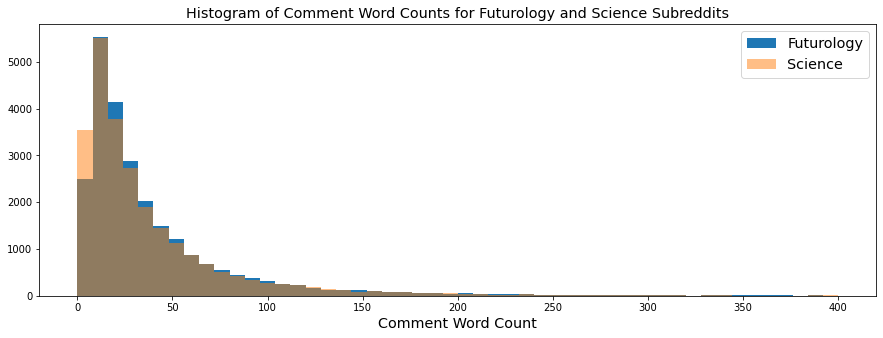

In [26]:
plt.figure(figsize=(15,5))
plot1 = plt.hist(future_word_count, bins=50, range=(0,400))
plot2 = plt.hist(science_word_count, alpha=0.5, bins=50, range=(0,400))
plt.title('Histogram of Comment Word Counts for Futurology and Science Subreddits', fontsize='x-large')
plt.xlabel('Comment Word Count', fontsize='x-large')
plt.legend(['Futurology', 'Science'], fontsize='x-large');

In [27]:
print(f'Futurology mean comment word count: {np.mean(future_word_count)}')
print(f'Science mean comment word count: {np.mean(science_word_count)}')

Futurology mean comment word count: 41.28328
Science mean comment word count: 39.2692


The above graph shows histograms for the distribution of word counts for comments on the science and futurology subreddits.  The tail of the histogram continues beyond the edge of this graph, but remains very small.

Although futurology comments are longer on average, the difference is quite small and mostly accounted for by the science subreddit having significantly more posts of ten words or less.

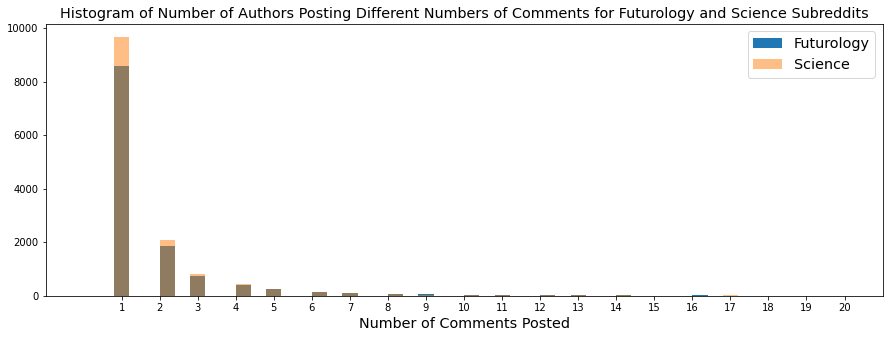

In [28]:
plt.figure(figsize=(15,5))
plot1 = plt.hist(future_df['author'].value_counts(), bins=50, range=(0,20))
plot2 = plt.hist(science_df['author'].value_counts(), alpha=0.5, bins=50, range=(0,20))
plt.title('Histogram of Number of Authors Posting Different Numbers of Comments for Futurology and Science Subreddits', fontsize='x-large')
plt.xlabel('Number of Comments Posted', fontsize='x-large')
plt.xticks(np.linspace(1,20,20))
plt.legend(['Futurology', 'Science'], fontsize='x-large');

In [29]:
print(f"Futurology unique comment authors: {len(future_df['author'].unique())}")
print(f"Science unique comment authors: {len(science_df['author'].unique())}")

Futurology unique comment authors: 12521
Science unique comment authors: 13806


In [30]:
future_df['comment_count'] = 1
author_num_comments = future_df['comment_count'].groupby(future_df['author']).sum()
author_num_comments[author_num_comments>10].sum()

4252

In [31]:
science_df['comment_count'] = 1
author_num_comments = science_df['comment_count'].groupby(science_df['author']).sum()
author_num_comments[author_num_comments>5].sum()

5804

In [32]:
4252/25000

0.17008

In [33]:
5804/25000

0.23216

The above histogram shows the distribution of number of authors posting different numbers of comments.  Recall that the Futurology comments cover a 2-week period and the Science comments cover a 1-week period.

We see that most authors made only a very small number of comments.  The average number of unique authors is very similar for each subreddit.  Also, considering an author who made more than 5 comments for Science and an author who made more than 10 comments for Futurology as a frequent commenter (because of the timeframe differce), I see that about 17% of Futurology comments and 24% of Science comments were made by frequent commenters.  It appears that the typical posted in the Science subreddit posts more often.

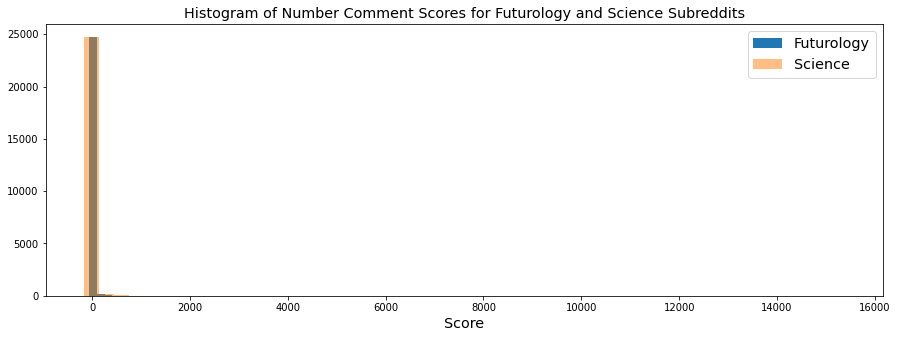

In [34]:
plt.figure(figsize=(15,5))
plot1 = plt.hist(future_df['score'], bins=50)
plot2 = plt.hist(science_df['score'], alpha=0.5, bins=50)
plt.title('Histogram of Number Comment Scores for Futurology and Science Subreddits', fontsize='x-large')
plt.xlabel('Score', fontsize='x-large')
plt.legend(['Futurology', 'Science'], fontsize='x-large');

In [35]:
future_df['score'][future_df['score'] > 2000]

6842     4867
15322    2948
18884    2385
23830    5672
24042    7866
Name: score, dtype: int64

In [36]:
science_df['score'][science_df['score'] > 2000]

30082     3340
30175     3514
30809     2358
33398     5805
34267     3157
34347     4556
34452    15384
35915     2788
37308     5365
39690     4268
40971     3634
48491     3099
Name: score, dtype: int64

Both subreddits have a small number of posts with scores that are very large outliers.  Let's focus on the distribution of scores for posts that are not such large outliers. Iteratively zooming in until I am focused on the main peak of scores yields the following histogram:

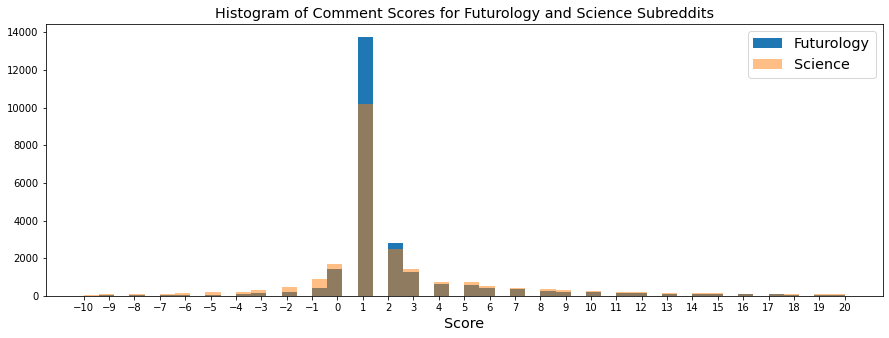

In [37]:
plt.figure(figsize=(15,5))
plot1 = plt.hist(future_df['score'], bins=50, range=(-10,20))
plot2 = plt.hist(science_df['score'], alpha=0.5, bins=50, range=(-10,20))
plt.title('Histogram of Comment Scores for Futurology and Science Subreddits', fontsize='x-large')
plt.xlabel('Score', fontsize='x-large')
plt.xticks(np.linspace(-10, 20, 31))
plt.legend(['Futurology', 'Science'], fontsize='x-large');

In [38]:
# Number of comments (out of 25,000) with scores between -10 and 20.
len(future_df[(future_df['score'] > -10) & (future_df['score'] < 20)])

23776

In [39]:
# Number of comments (out of 25,000) with scores between -10 and 20.
len(science_df[(science_df['score'] > -10) & (science_df['score'] < 20)])

22706

Score does not look like a particularly useful feature for prediction.  A very large majority of comments have low scores between -10 and 20, with a large peak at 0.  There are also large outliers that would likely need to be removed to avoid badly skewing the weights of the words in them.

In [40]:
sia = SentimentIntensityAnalyzer()
future_polarity = [sia.polarity_scores(comment)['compound'] for comment in future_df['body']]
science_polarity = [sia.polarity_scores(comment)['compound'] for comment in science_df['body']]

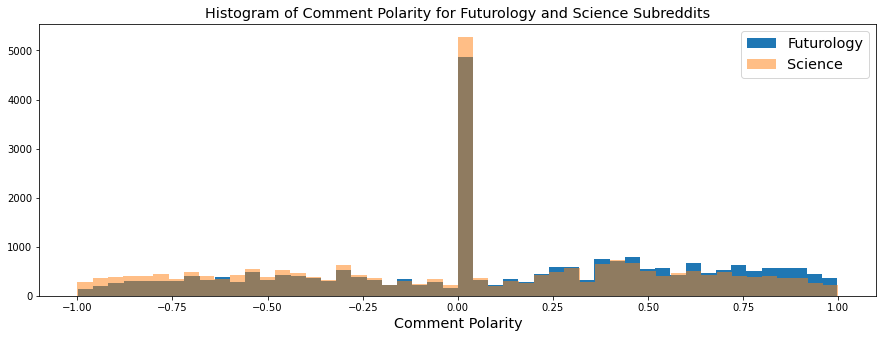

In [41]:
plt.figure(figsize=(15,5))
plot1 = plt.hist(future_polarity, bins=50)
plot2 = plt.hist(science_polarity, alpha=0.5, bins=50)
plt.title('Histogram of Comment Polarity for Futurology and Science Subreddits', fontsize='x-large')
plt.xlabel('Comment Polarity', fontsize='x-large')
plt.legend(['Futurology', 'Science'], fontsize='x-large');

Baed on the results of the sentiment intensity analyzer, there is little difference in the distribution of comment polarity in the Futuroloty and Science subreddits.  There is some difference at high and low polarities, suggesting a bit more optimism on the Futurology subreddit.  Both have plenty of posts across the full range, and I think it unlikely that this feature will be a useful addition to a predictive model.

Overall, EDA does suggest that it will be possible for a model to have some success differentiating between Science and Futurology posts.  The focus will be on NLP, as differences in top words suggested distinguishable trends.  Other features considered above include post length, comment scores, and sentiment.  There is some potential in each of these, but it is quite small. I will only add them if time allows.  Although Futurology does have more authors that post frequently, this is not a good parameter for modelling, as we may end up simply mapping frequent authors to the subreddit they comment on.  That is not the purpose of this analysis.